# eurostat death data weekly 

* https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mweek3&lang=en
* https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics

see also

https://www.euromomo.eu/graphs-and-maps

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns

## read raw data

In [2]:
raw = pd.read_csv('demo_r_mweek3_1_Data_byage.csv', thousands=',', parse_dates=['TIME'])
raw['YEAR'] = raw.TIME.str[:4].astype(int)
raw['WEEK'] = raw.TIME.str[5:].astype(int)
raw['Value'] = raw.Value.astype('float')

In [3]:
oldest = raw.AGE.unique()[14:19]
old = raw.AGE.unique()[12:14]
middle = raw.AGE.unique()[10:12]
young = raw.AGE.unique()[:10]

def agegroup(x):
    if x in oldest:
        return '>70'
    elif x in old:
        return '60-69'
    elif x in middle:
        return '50-59' 
    else:
        return '<50'

raw['GROUP'] = raw.AGE.apply(agegroup)

In [4]:
raw.dtypes

TIME      object
GEO       object
UNIT      object
SEX       object
AGE       object
Value    float64
YEAR       int64
WEEK       int64
GROUP     object
dtype: object

## aggregate the raw data by age and sex to get totals

https://stackoverflow.com/questions/45436873/pandas-how-to-create-a-datetime-object-from-week-and-year

In [6]:
df=raw.groupby(['TIME','YEAR','WEEK','GEO']).agg({'Value':np.sum}).reset_index().replace(0,np.nan)
#create the date column
df['DATE'] = pd.to_datetime(df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(df.WEEK.mul(7).astype(str) + ' days')
df['MONTH'] = df.DATE.dt.month

In [11]:
df

,TIME,YEAR,WEEK,GEO,Value,DATE,MONTH
0,2005W01,2005,1,Austria,1534.0,2005-01-08,1
1,2005W01,2005,1,Belgium,2339.0,2005-01-08,1
2,2005W01,2005,1,Bulgaria,NaN,2005-01-08,1
3,2005W01,2005,1,Croatia,982.0,2005-01-08,1
4,2005W01,2005,1,Czechia,2130.0,2005-01-08,1
...,...,...,...,...,...,...,...
25542,2021W52,2021,52,Slovenia,NaN,2021-12-31,12
25543,2021W52,2021,52,Spain,NaN,2021-12-31,12
25544,2021W52,2021,52,Sweden,NaN,2021-12-31,12
25545,2021W52,2021,52,Switzerland,NaN,2021-12-31,12


In [7]:
p = pd.pivot_table(df,index='DATE',columns='GEO',values='Value')
#x.columns = x.columns.get_level_values(1)
print (p.columns)
p[-3:]

Index(['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Greece',
       'Hungary', 'Iceland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom'],
      dtype='object', name='GEO')


GEO,Albania,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,...,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
DATE,,,,,,,,,,,,,,,,,,,,,
2021-12-17,NaN,NaN,2488.0,3036.0,NaN,NaN,NaN,NaN,374.0,NaN,...,NaN,2449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-24,NaN,NaN,NaN,2994.0,NaN,NaN,NaN,NaN,371.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
countries1 = ['France','Sweden','Denmark'] 
countries2 = ['France','Italy','Spain','Portugal','Austria','Denmark','Sweden','Norway']
all = ['Belgium','Switzerland','Sweden','Spain','Austria','Luxembourg',
       'Finland','Portugal','Slovenia','Slovakia','Norway','Lithunia','Estonia','Czechia','Latvia'] 

## monthly

In [17]:
x = df[df.GEO.isin(countries1)]
x.groupby('MONTH').agg({'Value':np.sum})

,Value
MONTH,
1,716283.0
2,666830.0
3,646353.0
4,775026.0
5,565235.0
6,542910.0
7,684173.0
8,542206.0
9,582713.0


## trend

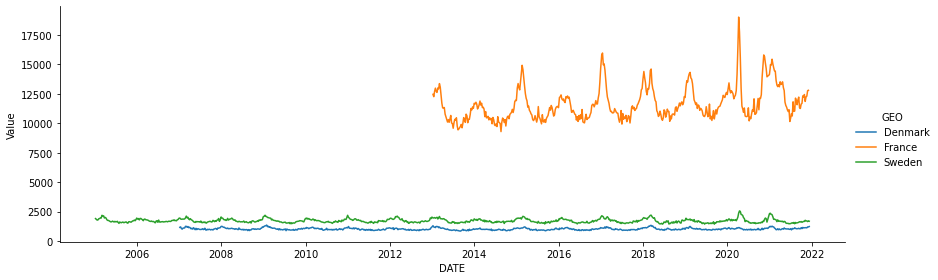

In [18]:
x = df[df.GEO.isin(countries1)]
g=sns.relplot(x='DATE',y='Value',data=x,kind='line',aspect=3,height=4,hue='GEO',estimator=np.sum,ci=None)
g.savefig('eurostat_flu_cycle.png')

## Plot totals up to week 26 per year for a subset of countries using catplot

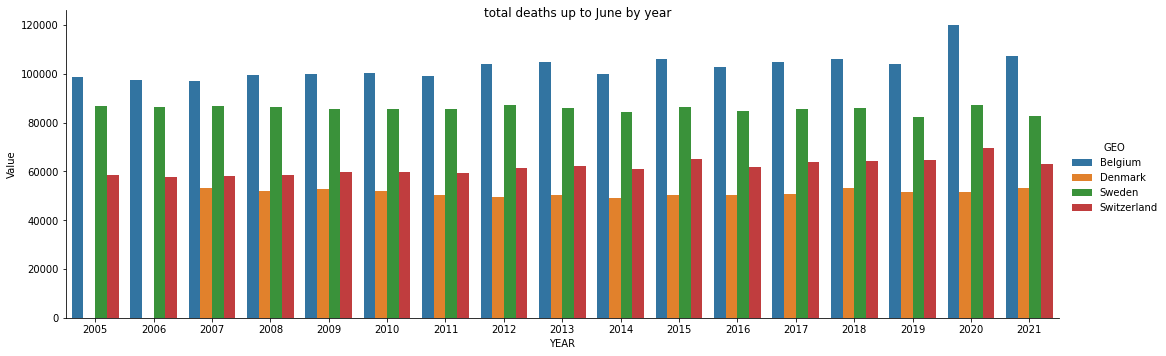

In [21]:
sub = df[df.WEEK<=50]
x = sub[sub.GEO.isin(countries1)]
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',aspect=3,hue='GEO',estimator=np.sum,ci=None)
g.fig.suptitle('total deaths up to June by year')
g.fig.savefig('eurostat_4countries_totaldeaths.png')

In [ ]:
sns.set_context("talk")
x = sub[sub.GEO.isin(all)]
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',aspect=1.5,col='GEO',col_wrap=4,height=4,sharey=False,estimator=np.sum,ci=None,color='lightblue')
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='center')
g.fig.savefig('eurostat_totaldeaths_bycountry.png')

In [ ]:
x = raw[raw.GEO=='Sweden']
g=sns.catplot(x='GEO',y='Value',data=x,kind='bar',aspect=2,hue='AGE',col='YEAR',col_wrap=2,
              sharey=False,estimator=np.sum,ci=None,palette='Set2')

## compare given period by age group

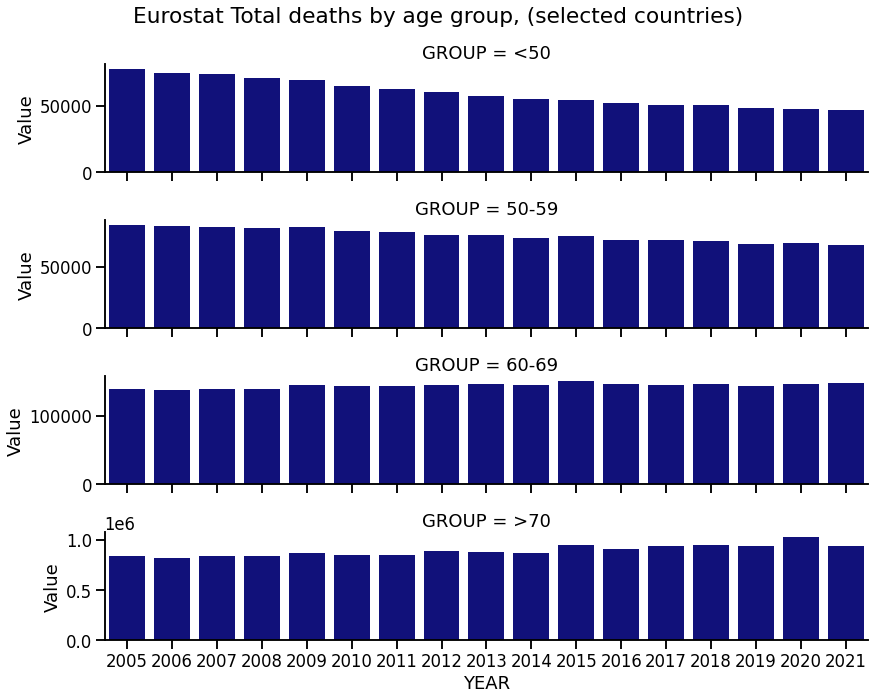

In [29]:
x = raw[raw.GEO.isin(all)]
#x = x[x.YEAR>2006]
#x = x[(x.WEEK>20) & (x.WEEK<50)] 
#remove france and italy which are incomplete for older years
x = x[~x.GEO.isin(countries2)]
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',sharey=False,aspect=5,height=2.5,row='GROUP',estimator=np.sum,ci=None,color='darkblue')
g.fig.suptitle('Eurostat Total deaths by age group, (selected countries)')
plt.subplots_adjust(top=0.9)
g.fig.savefig('eurostat_fluseason_deaths.png')

## covid peak shown with mean across years

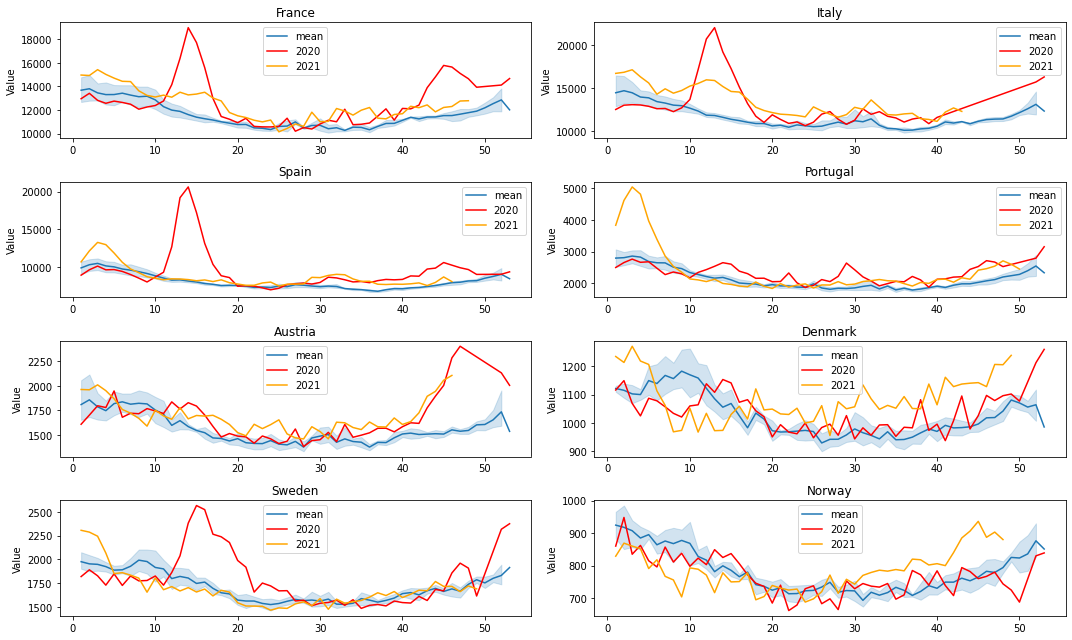

In [35]:
f,ax=plt.subplots(4,2,figsize=(15,9))
axs=ax.flat

def plot_trend(x,ax):
    mx = x[(x.YEAR<2020) & (x.YEAR>2014)]    
    sns.lineplot(x="WEEK", y="Value", data=mx,ax=ax,label='mean')
    s = x[x.YEAR==2020]
    sns.lineplot(x='WEEK',y='Value',data=s, color='red',ax=ax,label='2020')
    s = x[x.YEAR==2021]
    sns.lineplot(x='WEEK',y='Value',data=s, color='orange',ax=ax,label='2021')
    ax.set_xlabel('')
    ax.legend()
    return 

i=0
for c in countries2:    
    x = df[df.GEO==c]    
    g=plot_trend(x,ax=axs[i])    
    axs[i].set_title(c)
    i+=1
    
plt.tight_layout()
f.savefig('eurostat_2020peak_trend.png')

## age breakdown

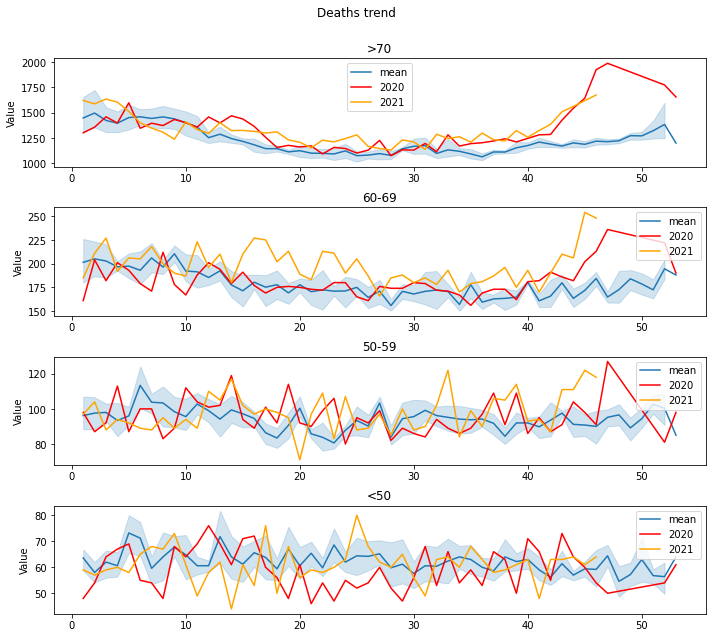

In [37]:
#print (oldest,old,middle,young)
cats = {'>70':oldest,'60-69':old,'50-59':middle,'<50':young}

f,ax=plt.subplots(4,1,figsize=(10,9))
axs=ax.flat
i=0
country='Austria'
for c in cats:    
    x = raw[(raw.GEO==country)]
    x = x[x.AGE.isin(cats[c])]
    x = x.groupby(['TIME','YEAR','WEEK','GEO']).agg({'Value':np.sum}).reset_index().replace(0,np.nan)
    g=plot_trend(x,ax=axs[i])    
    axs[i].set_title(c)
    i+=1   
plt.tight_layout()
f.suptitle('Deaths trend')
plt.subplots_adjust(top=0.9)
f.savefig('eurostat_2020peak_trend_byage_sweden.jpg')